Bayu Kurniawan
21/480093/GE/09662

Import Package

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.nn.modules.loss import BCEWithLogitsLoss
import rasterio
import numpy as np
import matplotlib
import os
import glob
import shutil
import matplotlib.pyplot as plt
import cv2
from IPython.core.pylabtools import figsize
from Model.load_data import CustomGeoDataset

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("[INFO] training using {} ...".format(DEVICE))

[INFO] training using cuda ...


Inisiasi lokasi dari directory data yang akan digunakan

In [5]:
data_dir = "./Data/lenet"
training_dir = "./Data/lenet/training"
if not os.path.isdir(training_dir):
    os.mkdir(training_dir)

test_dir = "./Data/lenet/testing"
if not os.path.isdir(test_dir):
    os.mkdir(test_dir)

sampah_train = os.path.join(training_dir, "sampah_train")
if not os.path.isdir(sampah_train):
    os.mkdir(sampah_train)

nsampah_train = os.path.join(training_dir, "non_sampah_train")
if not os.path.isdir(nsampah_train):
    os.mkdir(nsampah_train)

sampah_val = os.path.join(test_dir, "sampah_val")
if not os.path.isdir(sampah_val):
    os.mkdir(sampah_val)

nsampah_val = os.path.join(test_dir, "non_sampah_val")
if not os.path.isdir(nsampah_val):
    os.mkdir(nsampah_val)

Menentukan Split Size

In [6]:
split_size = 0.80
sampah_imgs_size = len(glob.glob("./Data/lenet/sampah/*.tif"))
nsampah_imgs_size = len(glob.glob("./Data/lenet/non_sampah/*.tif"))

print(sampah_imgs_size)
print(nsampah_imgs_size)

411
284


Mengambil sampel dari data sampah dan non sampah yang telah disediakan

In [7]:
for i, img in enumerate(glob.glob("./Data/lenet/sampah/*.tif")):
    if i < (sampah_imgs_size * split_size):
        shutil.copy(img, sampah_train)
    else:
        shutil.copy(img, sampah_val)

for i, img in enumerate(glob.glob("./Data/lenet/non_sampah/*.tif")):
    if i < (nsampah_imgs_size * split_size):
        shutil.copy(img, nsampah_train)
    else:
        shutil.copy(img, nsampah_val)


Memuat dan menampilkan sampel citra

./Data/lenet/training\non_sampah_train\0_32_0336.tif
non_sampah_train
(32, 32, 3)


<Axes: >

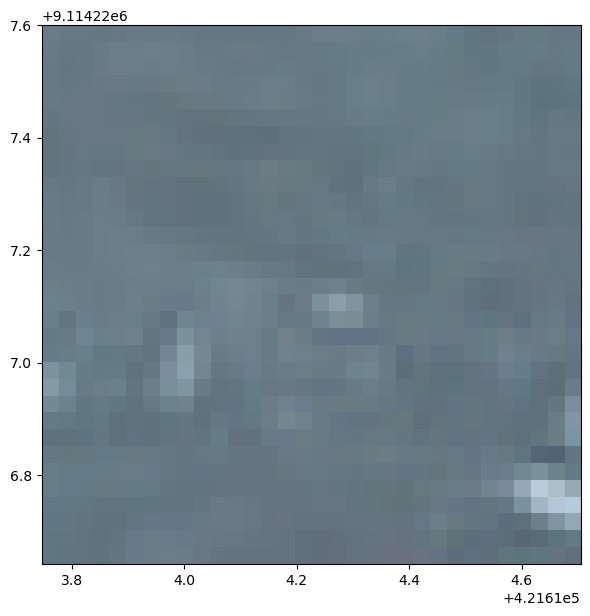

In [8]:
import matplotlib.pyplot as plt
from rasterio.plot import show

samples_sampah = [os.path.join(sampah_train,np.random.choice(os.listdir(sampah_train),1)[0]) for _ in range(8)]
samples_nsampah = [os.path.join(nsampah_train,np.random.choice(os.listdir(nsampah_train),1)[0]) for _ in range(8)]

print(samples_nsampah[0])

t = samples_nsampah[0].split('\\')
print(t[1])

full_dataset = rasterio.open(samples_sampah[0])

img = full_dataset.read([3,2,1])
#img2 = np.moveaxis(img, 0, -1)
img2 = img.transpose(1,2,0)
print(img2.shape)
fig, ax = plt.subplots(figsize = (10, 7))
show(img[:,:,:], ax = ax, transform=full_dataset.transform) #plot data dalam koordinat citra


Membagi menjadi data pelatihan dan data uji, serta menyiapkan dataset kustom dan dataloader

In [10]:
from Model.load_data import CustomGeoDataset
import glob

#train_data = datasets.ImageFolder(training_dir,transform=train_transforms)
train_data = glob.glob(training_dir + "/**/*.tif", recursive=True)
print(train_data[0])
test_data = glob.glob(test_dir + "/**/*.tif", recursive=True)
print(len(test_data))

training_label = []
test_label = []

for i, pt in enumerate(train_data):
    lst = pt
    lst_split = lst.split('\\')
    lst_split = lst_split[1]
    if lst_split == 'non_sampah_train':
        training_label.append(0)
    else:
        training_label.append(1)

print(len(training_label))

for i, pt in enumerate(test_data):
    lst = pt
    lst_split = lst.split('\\')
    lst_split = lst_split[1]
    if lst_split == 'non_sampah_val':
        test_label.append(0)
    else:
        test_label.append(1)
    
print(len(test_label))

# Define custom data augmentation/transformations
custom_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    # Add more transformations as needed
])

# Instantiate the custom dataset with transformations
train_data = CustomGeoDataset(train_data, training_label, custom_transforms)
test_data = CustomGeoDataset(test_data, test_label, custom_transforms)

#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=12)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=12)

print(len(trainloader))
print(len(testloader))


./Data/lenet/training\non_sampah_train\0_32_010.tif
138
557
138
47
12


Membuat training step

In [12]:
def make_train_step(model, optimizer, loss_fn):
    def train_step(x, y):
        #make prediction
        yhat = model(x)
        #enter train mode
        model.train()
        #compute loss
        loss = loss_fn(yhat, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        return loss
    return train_step

Mengambil model yang telah ada untuk running CNN LeNet

In [13]:
from Model.cnn import cnn

modelcnn = cnn()
print(modelcnn)
modelcnn = modelcnn.to(DEVICE)

cnn(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)


Mendefinisikan epoch, optimiser yang akan digunakan

In [14]:
from torch.optim import Adam

# define learning parameters
INIT_LR = 1e-4
epochs = 20

# initialize our optimizer and loss function
optimizer = Adam(modelcnn.parameters(), lr=INIT_LR)
lossfn = BCEWithLogitsLoss()

#train step
train_step = make_train_step(modelcnn, optimizer, lossfn)
print(train_step)

<function make_train_step.<locals>.train_step at 0x000001E2E8FEC7C0>


Melakukan training terhadap data

100%|██████████| 47/47 [00:04<00:00, 11.08it/s]



Epoch : 1, train loss : 0.6886593103408813
Epoch : 1, val loss : 0.646615743637085, val accuracy: 40.57971014492754%


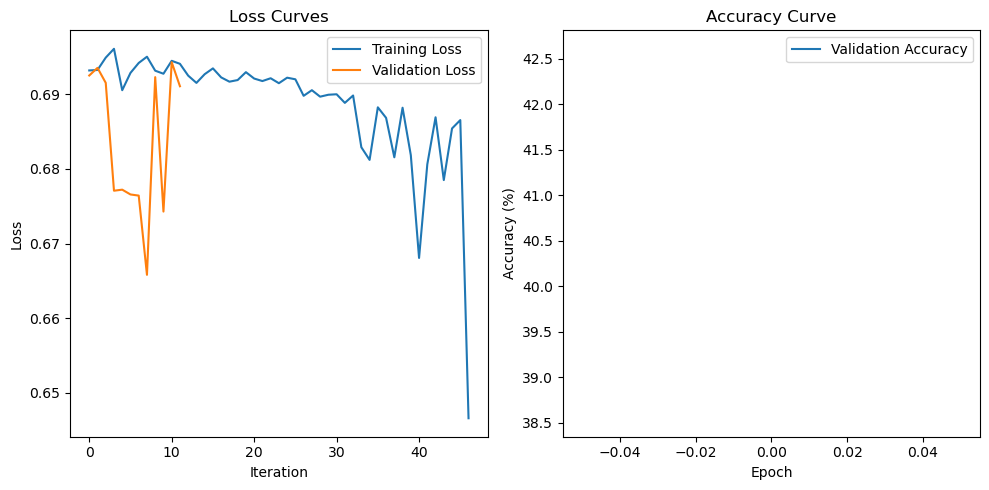

100%|██████████| 47/47 [00:03<00:00, 15.21it/s]



Epoch : 2, train loss : 0.6737658977508545
Epoch : 2, val loss : 0.7263478636741638, val accuracy: 42.028985507246375%


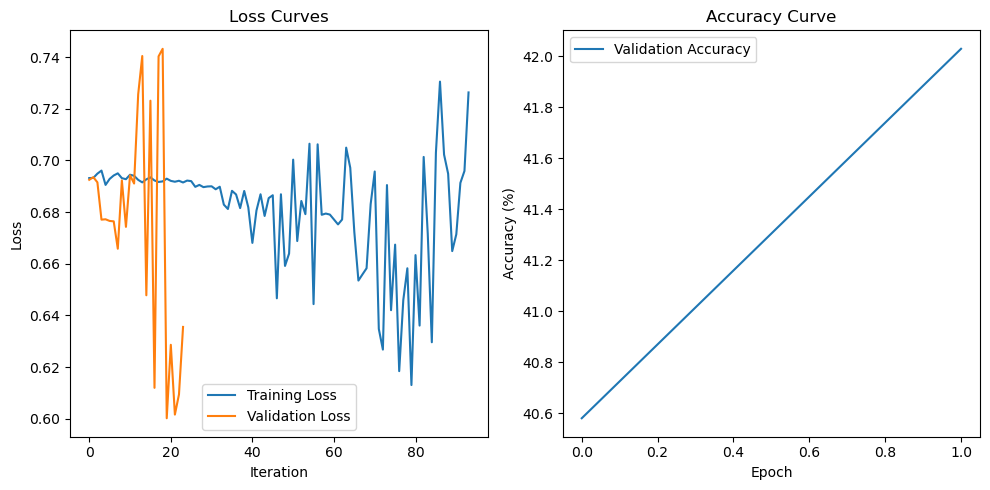

100%|██████████| 47/47 [00:02<00:00, 16.23it/s]



Epoch : 3, train loss : 0.660865306854248
Epoch : 3, val loss : 0.6473755836486816, val accuracy: 64.4927536231884%


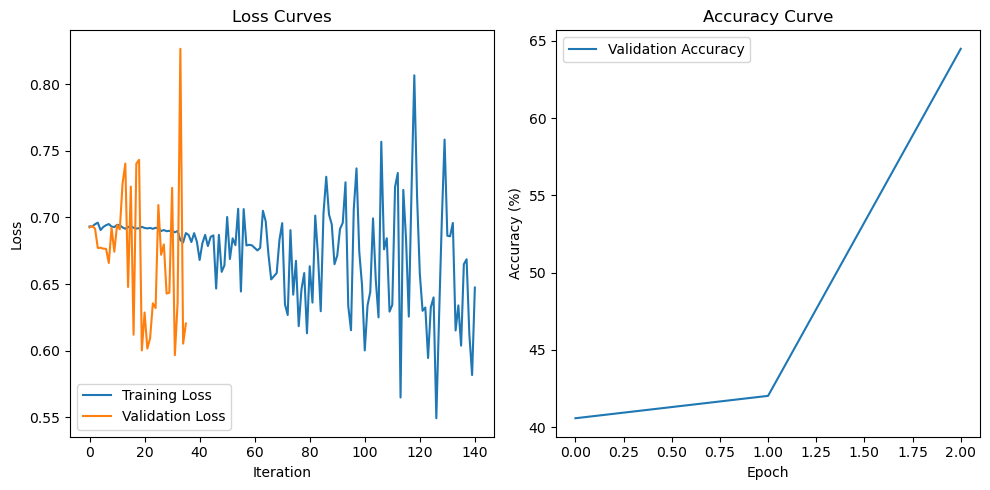

100%|██████████| 47/47 [00:03<00:00, 14.65it/s]



Epoch : 4, train loss : 0.6581035256385803
Epoch : 4, val loss : 0.7245576977729797, val accuracy: 70.28985507246377%


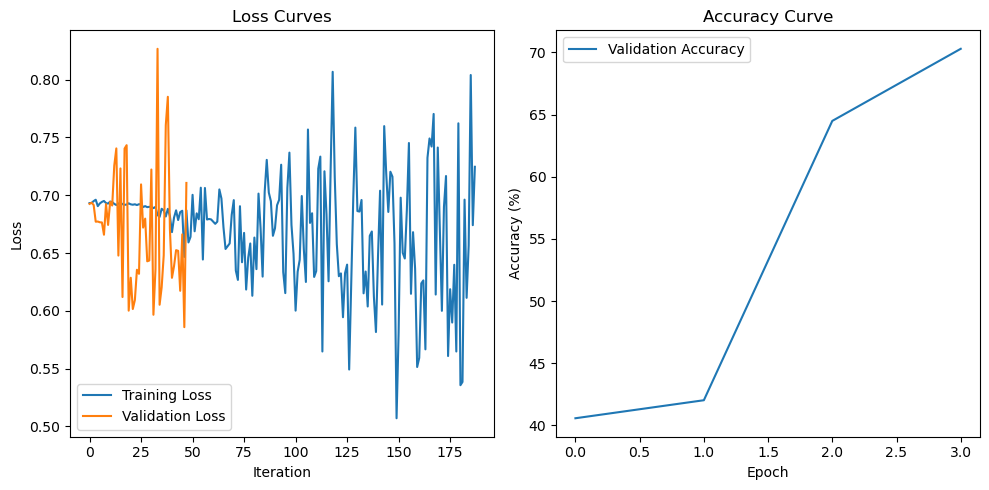

100%|██████████| 47/47 [00:03<00:00, 14.56it/s]



Epoch : 5, train loss : 0.6498370170593262
Epoch : 5, val loss : 0.6357154846191406, val accuracy: 42.7536231884058%


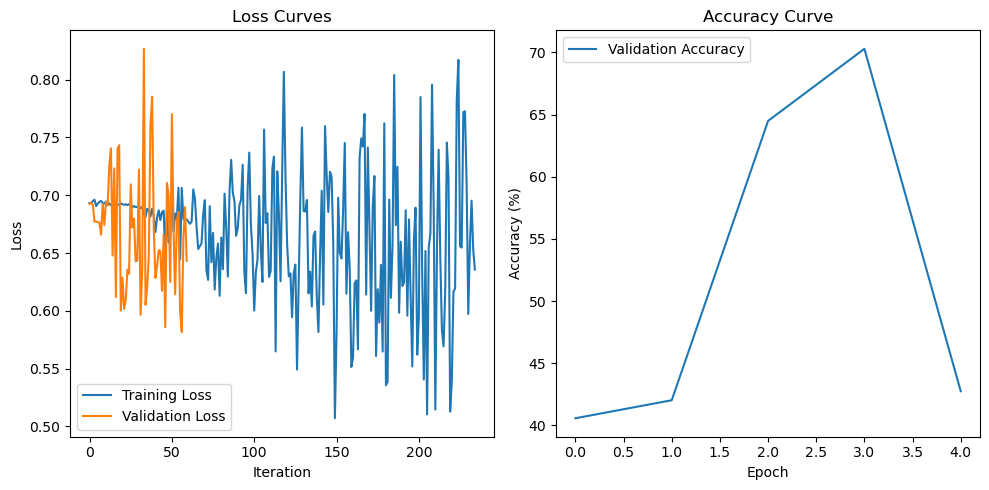

100%|██████████| 47/47 [00:03<00:00, 15.28it/s]



Epoch : 6, train loss : 0.6452664732933044
Epoch : 6, val loss : 0.7151298522949219, val accuracy: 68.1159420289855%


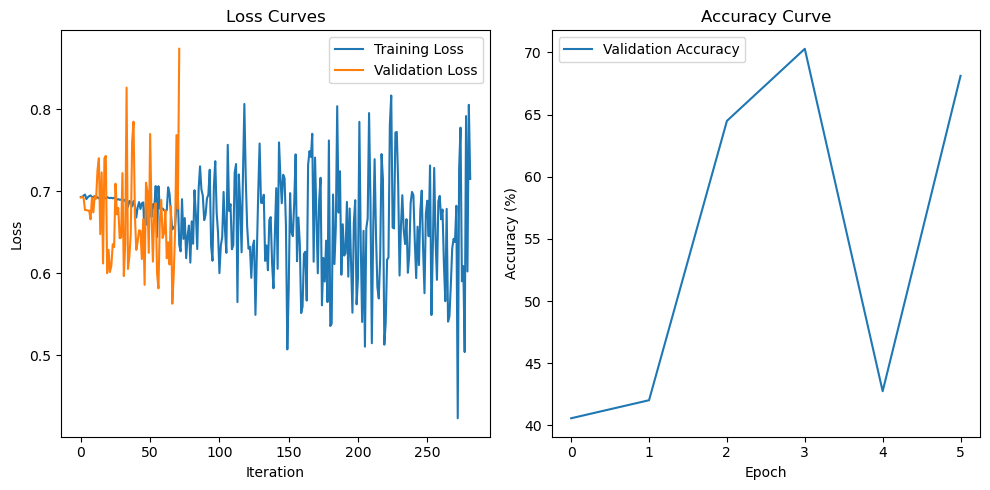

100%|██████████| 47/47 [00:03<00:00, 14.21it/s]



Epoch : 7, train loss : 0.6285572052001953
Epoch : 7, val loss : 0.5884428024291992, val accuracy: 62.31884057971015%


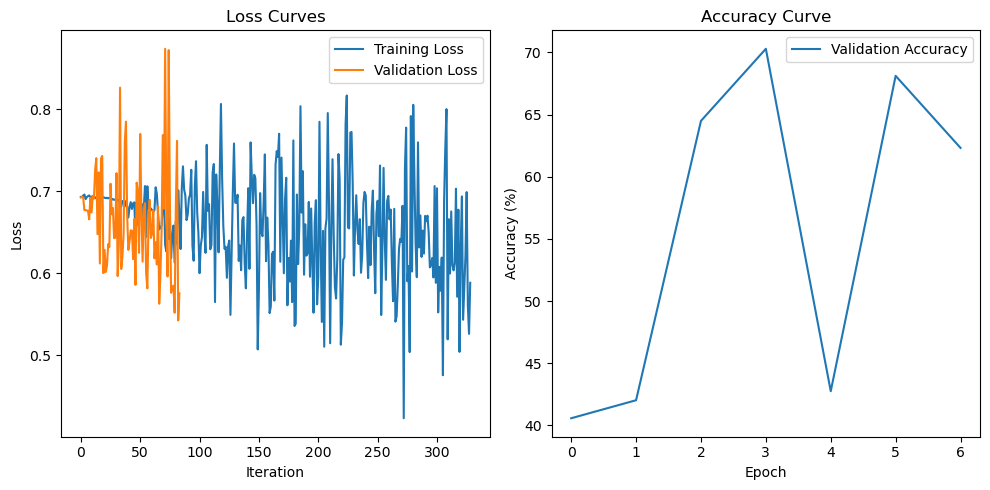

100%|██████████| 47/47 [00:03<00:00, 13.88it/s]



Epoch : 8, train loss : 0.6066921949386597
Epoch : 8, val loss : 0.7614338994026184, val accuracy: 66.66666666666667%


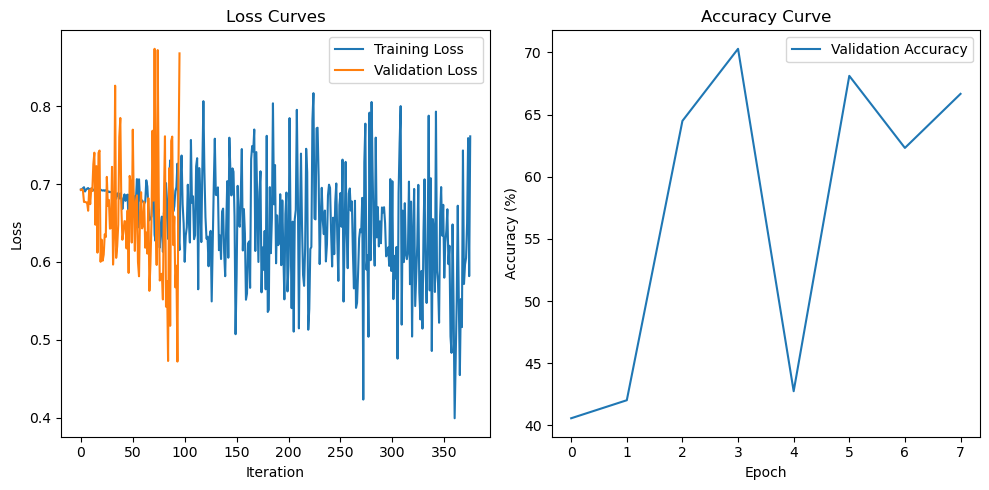

100%|██████████| 47/47 [00:02<00:00, 16.13it/s]



Epoch : 9, train loss : 0.5780652165412903
Epoch : 9, val loss : 0.5274155735969543, val accuracy: 58.69565217391305%


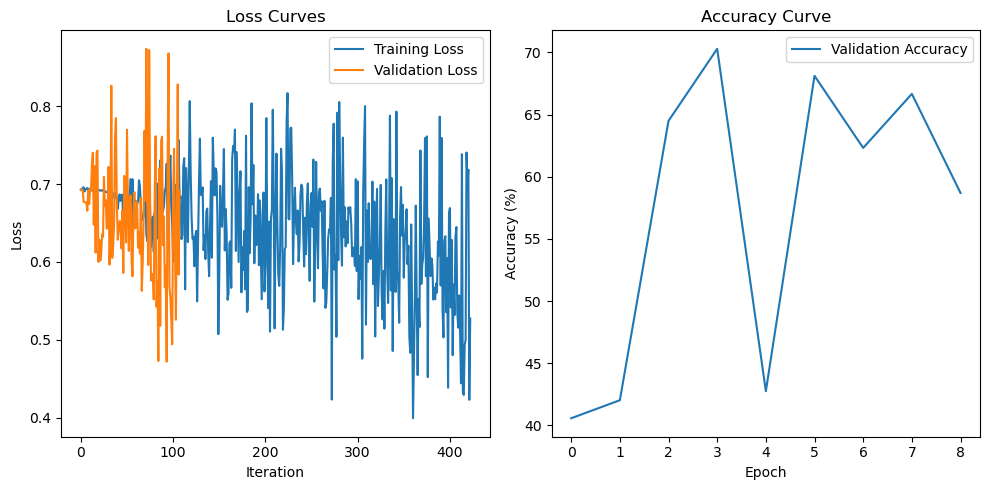

100%|██████████| 47/47 [00:02<00:00, 15.97it/s]



Epoch : 10, train loss : 0.546986997127533
Epoch : 10, val loss : 0.5511711835861206, val accuracy: 67.3913043478261%


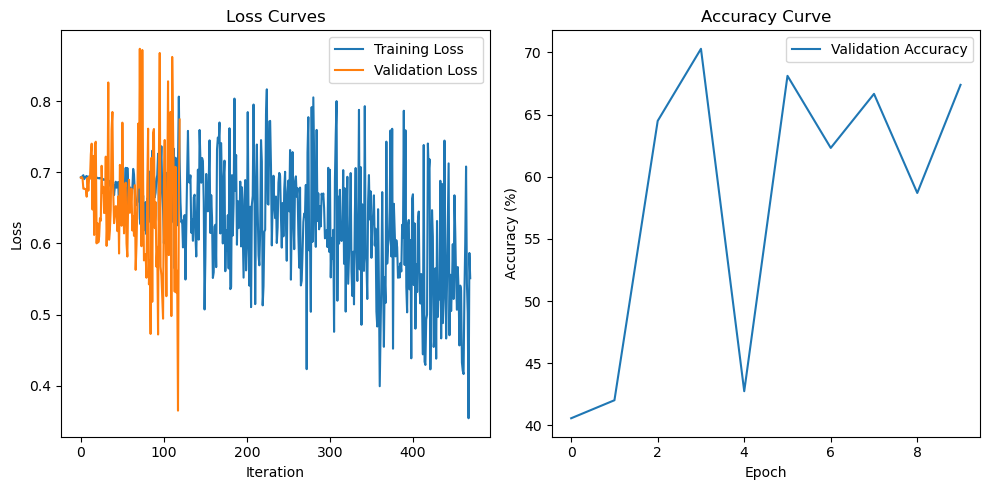

100%|██████████| 47/47 [00:03<00:00, 14.87it/s]



Epoch : 11, train loss : 0.5479958057403564
Epoch : 11, val loss : 0.5193823575973511, val accuracy: 62.31884057971015%


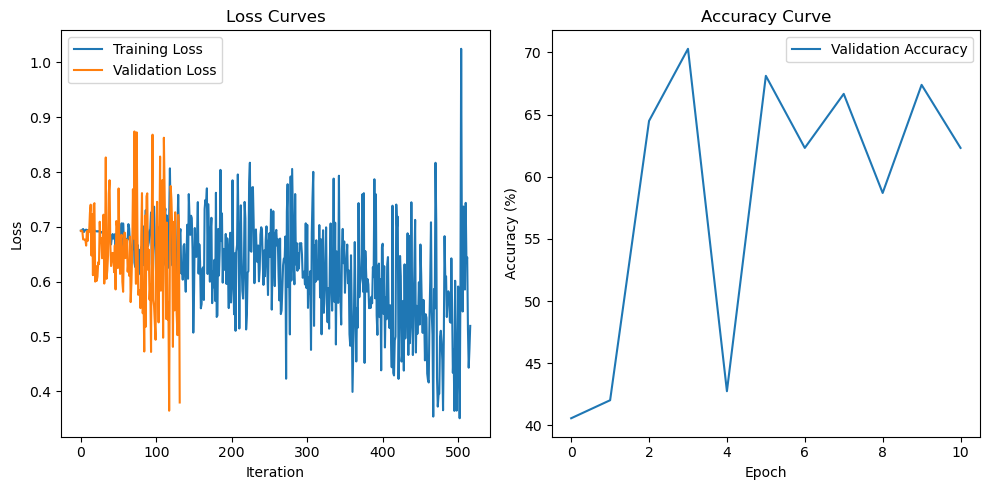

100%|██████████| 47/47 [00:03<00:00, 15.16it/s]



Epoch : 12, train loss : 0.5282703042030334
Epoch : 12, val loss : 0.5304519534111023, val accuracy: 63.04347826086956%


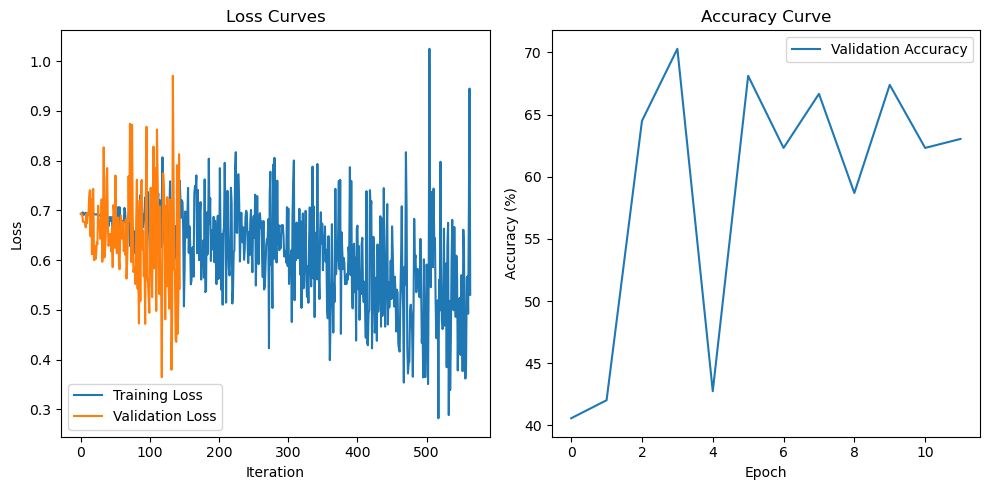

100%|██████████| 47/47 [00:03<00:00, 14.51it/s]



Epoch : 13, train loss : 0.5354095101356506
Epoch : 13, val loss : 0.48284944891929626, val accuracy: 66.66666666666667%


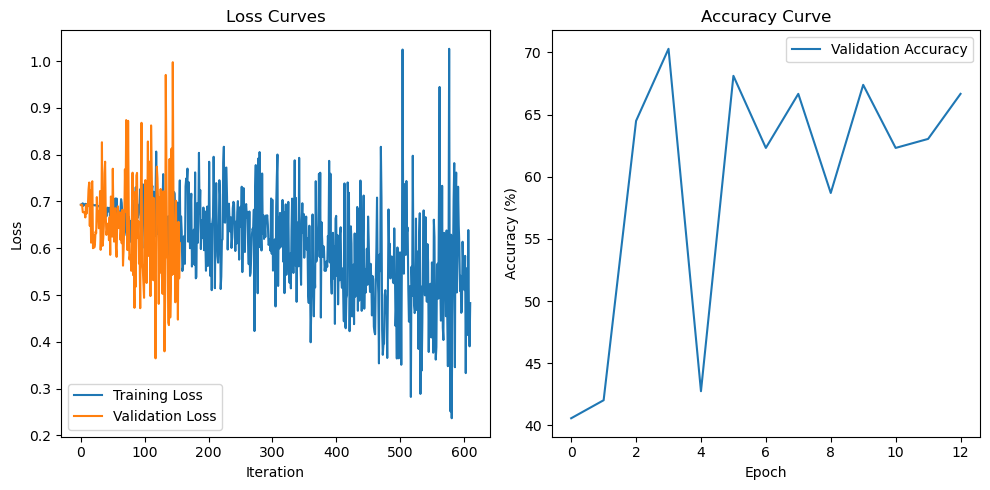

100%|██████████| 47/47 [00:02<00:00, 16.01it/s]



Epoch : 14, train loss : 0.517896294593811
Epoch : 14, val loss : 0.4505409002304077, val accuracy: 64.4927536231884%


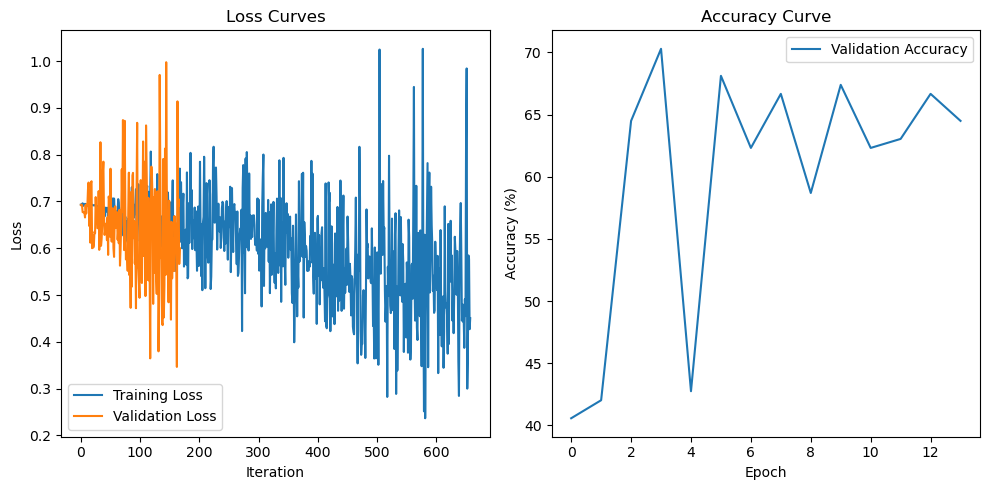

100%|██████████| 47/47 [00:03<00:00, 15.58it/s]



Epoch : 15, train loss : 0.5165219306945801
Epoch : 15, val loss : 0.43445920944213867, val accuracy: 62.31884057971015%


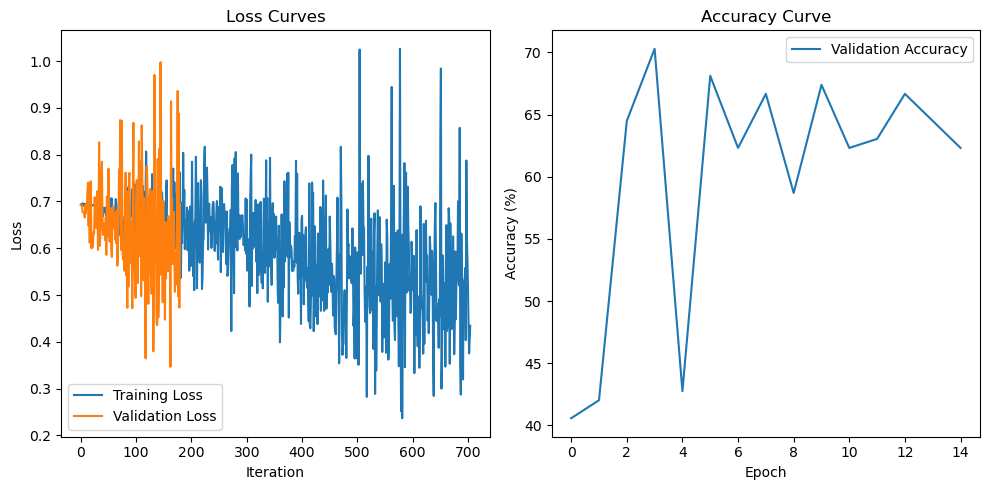

100%|██████████| 47/47 [00:03<00:00, 14.67it/s]



Epoch : 16, train loss : 0.5078709125518799
Epoch : 16, val loss : 0.31556978821754456, val accuracy: 63.04347826086956%


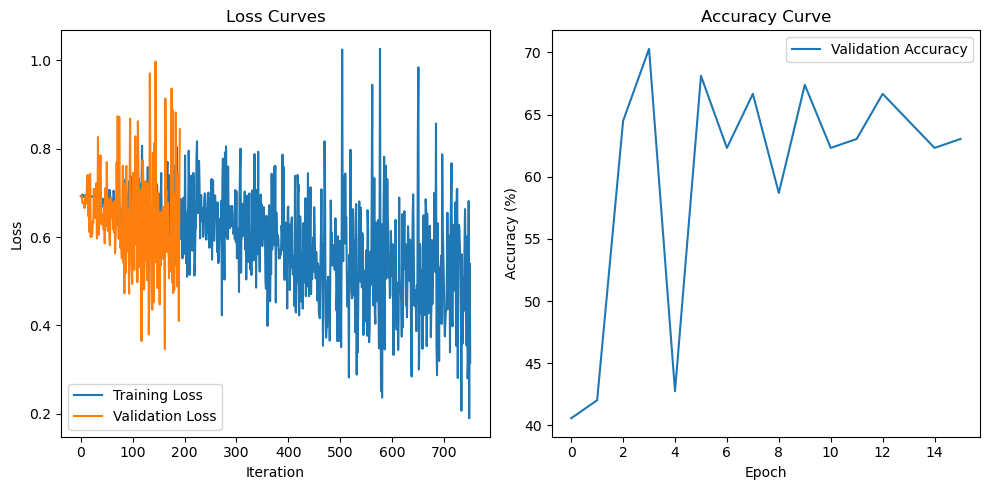

100%|██████████| 47/47 [00:03<00:00, 15.63it/s]



Epoch : 17, train loss : 0.5158240795135498
Epoch : 17, val loss : 0.523532509803772, val accuracy: 60.869565217391305%


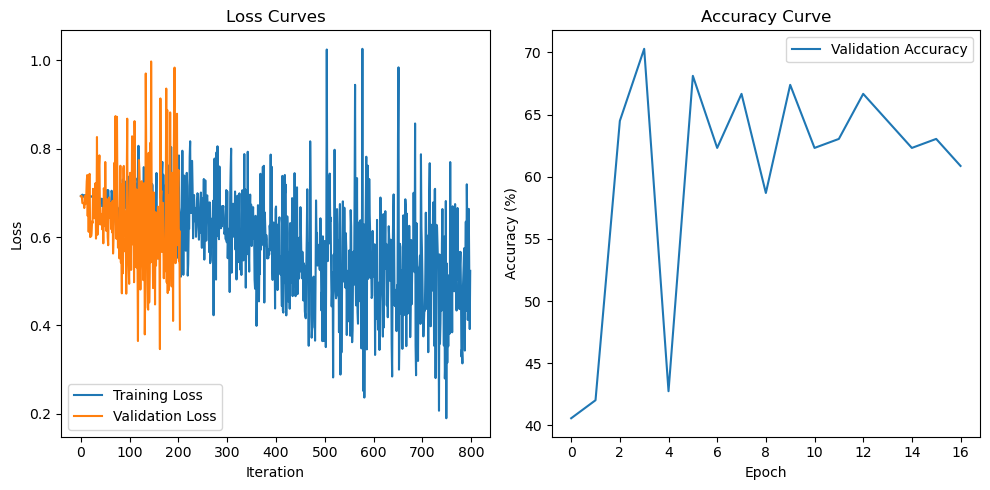

100%|██████████| 47/47 [00:03<00:00, 15.35it/s]



Epoch : 18, train loss : 0.5125605463981628
Epoch : 18, val loss : 0.6974249482154846, val accuracy: 60.869565217391305%


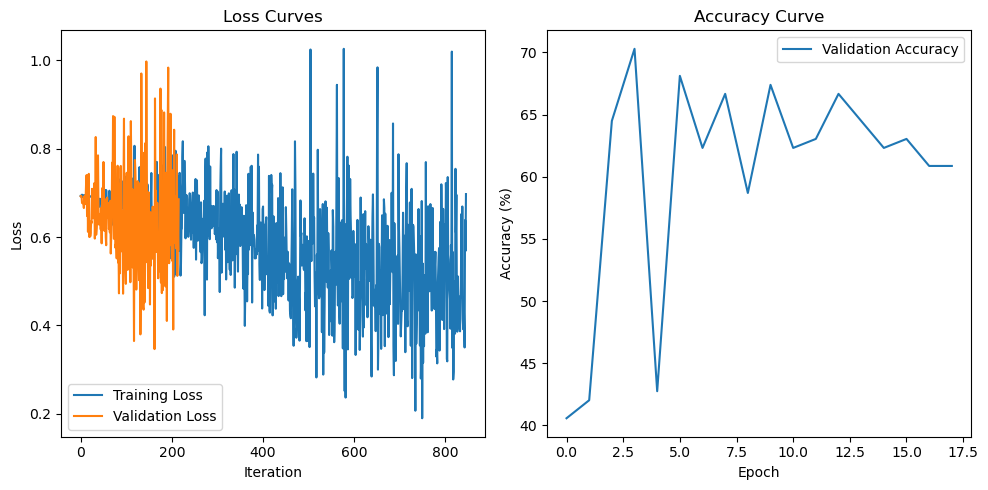

100%|██████████| 47/47 [00:03<00:00, 14.85it/s]



Epoch : 19, train loss : 0.5085015892982483
Epoch : 19, val loss : 0.9866666793823242, val accuracy: 65.94202898550725%


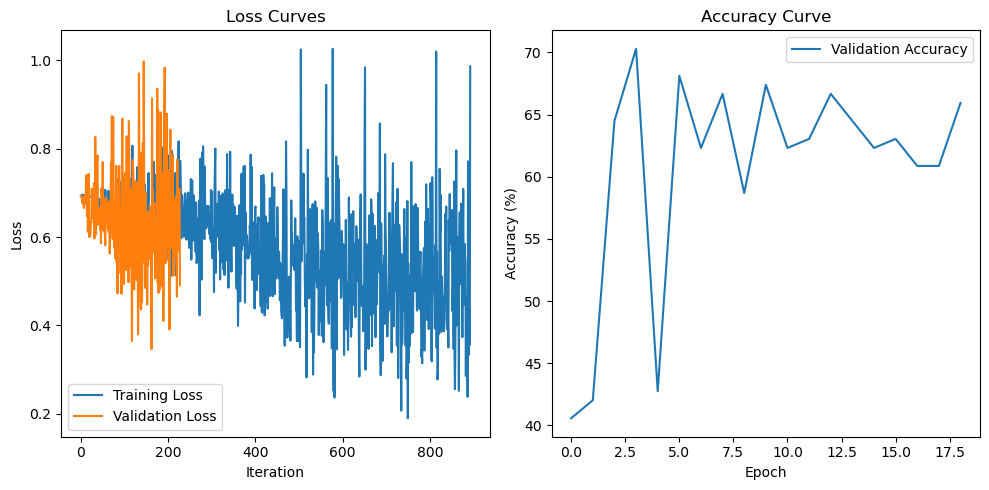

100%|██████████| 47/47 [00:02<00:00, 15.85it/s]



Epoch : 20, train loss : 0.5004696846008301
Epoch : 20, val loss : 0.1430986374616623, val accuracy: 63.04347826086956%


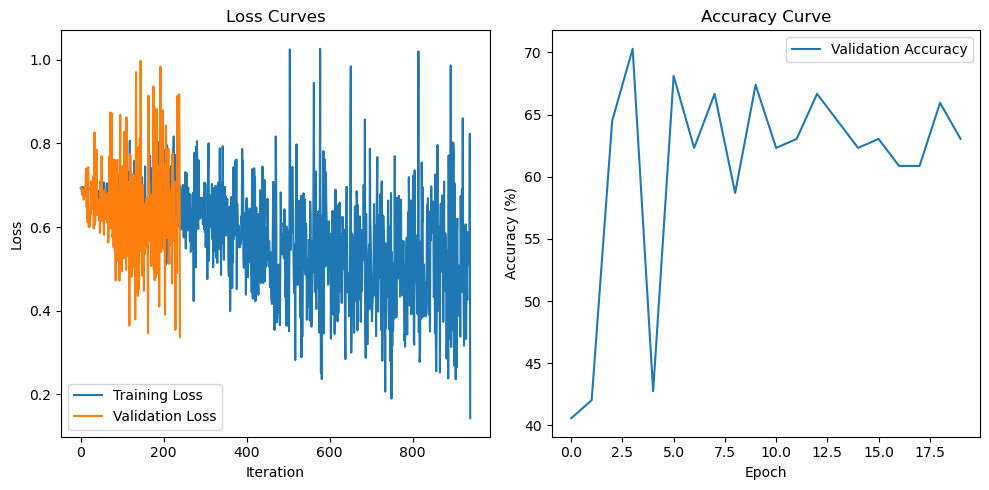

<All keys matched successfully>

In [15]:
from tqdm import tqdm

losses = []
val_losses = []
epoch_train_losses = []
epoch_test_losses = []
accuracies = [] 

early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(epochs):
    epoch_loss = 0
    total = 0
    correct = 0
    for i, data in tqdm(enumerate(trainloader), total = len(trainloader)):
        x_batch, y_batch = data
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.unsqueeze(1).float()
        y_batch = y_batch.to(DEVICE)

        loss = train_step(x_batch, y_batch)
        epoch_loss += loss/len(trainloader)
        losses.append(loss)
    
    epoch_train_losses.append(epoch_loss)
    print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

    #validation (no gradient)
    with torch.no_grad():
        cum_loss = 0
        for x_batch, y_batch in testloader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.unsqueeze(1).float()
            y_batch = y_batch.to(DEVICE)

            #model evaluation
            modelcnn.eval()
            
            yhat = modelcnn(x_batch)
            val_loss = lossfn(yhat, y_batch)
            cum_loss += loss/len(testloader)
            val_losses.append(val_loss.item())

            #calculate accuracy
            predicted = yhat > 0.5
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        
        epoch_test_losses.append(cum_loss)
        print('Epoch : {}, val loss : {}, val accuracy: {}%'.format(epoch+1, cum_loss, accuracy))

        best_loss = min(epoch_test_losses)

        #simpan model terbaik
        if cum_loss <= best_loss:
            best_model_wts = modelcnn.state_dict()
    
    losses_cpu = torch.tensor(losses, device='cpu')
    val_losses_cpu = torch.tensor(val_losses, device='cpu')
        
    # Plot loss and accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses_cpu, label='Training Loss')
    plt.plot(val_losses_cpu, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()
            
#load best model
modelcnn.load_state_dict(best_model_wts)

    




Hasil pembelajaran disimpan dalam model

In [16]:
torch.save(modelcnn, "./modelcnn.pth")
#bisa save model, bisa save bobot dan parameter serta checkpoint
#load model semisal next time mau dipanggil torch.load('modelcnn.pth')

In [ ]:
from Model.split_image import split
test_image = "./Data/test_data.tif"
split(test_image, 32, 16)


In [22]:
#sebelum running steps ini, pindahkan dulu data ke folder split
split_folder = "./split/"
split_image = glob.glob(os.path.join(split_folder, "*.tif"))
print(len(split_image))

5888


Melakukan prediksi untuk satu image

In [ ]:
#testing object detection untuk satu image

import torchvision.transforms as F

t1 = split_image[0]
filename = os.path.basename(t1)
print(filename)

#buka data
t2 = rasterio.open(t1)
t3 = t2.read(indexes = (1,2,3))

#data dikonversi ke 0-1 dengan membagi menjadi nilai maksimal citra, fungsi ini didefinisikan pada script load data sehingga perlu diterapkan
t3 = t3/255

# Convert menjadi float32 karena pytorch butuh input dalam float
t3_flts = t3.astype(np.float32)

# Convert menjadi torch tensor, simpan dalam device yang digunakan dalam proses komputasi (cpu/gpu)
t3_tensor = torch.from_numpy(t3_flts).to(DEVICE)

# klasifikasi dengan model alexnet
t3_pred = modelcnn(t3_tensor)
t3_pred = torch.sigmoid(t3_pred) # diperlukan saat klasifikasi binary untuk mengubah hasil prediksi menjadi probablitas dengan nilai 0 - 1
t3_pred = t3_pred.cpu().detach().numpy()
t3_prob = t3_pred[0]
print(t3_prob)

#kelaskan menjadi 0 atau 1 (binary mapping)
threshold = 0.5
t3_class = 1 if t3_prob > threshold else 0
print(t3_class)

#ubah menjadi array dengan ukuran 32 x 32 
zero_img = np.zeros((32, 32, 1))
print(zero_img.shape)
zero_img = zero_img + t3_class
print(zero_img.mean())

#ubah shape menjadi format rasterio (Channel, Height, Widht)
zero_img = np.moveaxis(zero_img, 2, 0)
print(zero_img.shape)

#ubah menjadi raster
out_meta = t2.meta
out_meta.update({'driver':'GTiff', 'height':32, 'width':32, 'count':1, 'crs': t2.crs, 'transforms': t2.transform})
with rasterio.open('hasil_lenet_{}_{}'.format(t3_class, filename), 'w', **out_meta) as object:
    object.write(zero_img)



In [ ]:
#buat loop untuk proses cnn ke seluruh data split

LOOPING CNN LENET

Memanggil model yang telah dibangun sebelumnya

In [23]:
modelalex = torch.load('modelcnn.pth')
modelalex = modelalex.to(DEVICE)

Melakukan iterasi terhadap semua data split

In [24]:
import os
import rasterio
import numpy as np
import torch
import torchvision.transforms as F
from PIL import Image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Iterate over each image in split_image
for idx, t1 in enumerate(split_image):
    
    filename = os.path.basename(t1)
    
    # Open the image data
    with rasterio.open(t1) as t2:
        t3 = t2.read(indexes=(1, 2, 3))

    # Normalize data to range 0-1
    t3 = t3 / 255.0

    # Convert to float32 as PyTorch requires float input
    t3_flts = t3.astype(np.float32)

    # Convert to torch tensor and move to the appropriate device (CPU/GPU)
    t3_tensor = torch.from_numpy(t3_flts).to(DEVICE)

    # Classify with the model (alexnet assumed)
    t3_pred = modelcnn(t3_tensor)
    t3_pred = torch.sigmoid(t3_pred)  # For binary classification to get probabilities between 0 and 1
    t3_pred = t3_pred.cpu().detach().numpy()
    t3_prob = t3_pred[0]
    print(t3_prob)

    # Binary mapping
    threshold = 0.5
    t3_class = 1 if t3_prob > threshold else 0
    print(t3_class)

    # Create an array with size 32 x 32
    zero_img = np.zeros((32, 32, 1))
    print(zero_img.shape)
    zero_img += t3_class
    print(zero_img.mean())

    # Change shape to rasterio format (Channel, Height, Width)
    zero_img = np.moveaxis(zero_img, 2, 0)
    print(zero_img.shape)

    # Update metadata for output raster
    out_meta = t2.meta.copy()
    out_meta.update({'driver': 'GTiff', 'height': 32, 'width': 32, 'count': 1, 'crs': t2.crs, 'transform': t2.transform})
    
    # Save the raster
    output_filename = f'hasil_lenet_{t3_class}_{idx}_{filename}'
    with rasterio.open(output_filename, 'w', **out_meta) as dst:
        dst.write(zero_img)
    print(f"Processed {filename} ({idx + 1} of {len(split_image)})")

print("All images processed.")


[0.73801637]
1
(32, 32, 1)
1.0
(1, 32, 32)
Processed crop_0_0.tif (1 of 5888)
[0.2808834]
0
(32, 32, 1)
0.0
(1, 32, 32)
Processed crop_0_1008.tif (2 of 5888)
[0.57362854]
1
(32, 32, 1)
1.0
(1, 32, 32)
Processed crop_0_1024.tif (3 of 5888)
[0.6624665]
1
(32, 32, 1)
1.0
(1, 32, 32)
Processed crop_0_1040.tif (4 of 5888)
[0.6191733]
1
(32, 32, 1)
1.0
(1, 32, 32)
Processed crop_0_1056.tif (5 of 5888)
[0.51966673]
1
(32, 32, 1)
1.0
(1, 32, 32)
Processed crop_0_1072.tif (6 of 5888)
[0.29727086]
0
(32, 32, 1)
0.0
(1, 32, 32)
Processed crop_0_1088.tif (7 of 5888)
[0.20946221]
0
(32, 32, 1)
0.0
(1, 32, 32)
Processed crop_0_1104.tif (8 of 5888)
[0.76659536]
1
(32, 32, 1)
1.0
(1, 32, 32)
Processed crop_0_112.tif (9 of 5888)
[0.41254607]
0
(32, 32, 1)
0.0
(1, 32, 32)
Processed crop_0_1120.tif (10 of 5888)
[0.6148144]
1
(32, 32, 1)
1.0
(1, 32, 32)
Processed crop_0_1136.tif (11 of 5888)
[0.7273393]
1
(32, 32, 1)
1.0
(1, 32, 32)
Processed crop_0_1152.tif (12 of 5888)
[0.68765885]
1
(32, 32, 1)
1.0
(1,

Menginisiasi untuk data hasil iterasi untuk dilakukan mosaik

In [28]:
input_dir = 'OutputLenet/'
output_file = 'mosaiclenet.tif'

tif_files = glob.glob(os.path.join(input_dir, '*.tif'))
src_files_to_mosaic = []
for fp in tif_files:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

Proses mosaik

In [29]:
from rasterio.merge import merge
mosaic, out_trans = merge(src_files_to_mosaic)

Hasil mosaik disimpan dan dapat dibuka di ArcMap, ArcGIS Pro, atau software lainnya

In [30]:
out_meta = src_files_to_mosaic[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "count": mosaic.shape[0]  # number of channels
})
with rasterio.open(output_file, "w", **out_meta) as dest:
    dest.write(mosaic)